<a href="https://colab.research.google.com/github/mvince33/Coding-Dojo/blob/main/week07/mock_belt_exam2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [190]:
# Imports
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the data

In [27]:
# Load the data
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR_KGkBJ2SVLehdDAVli_xW-dyLeOdClGm15iksUQO62Sre6il85nVfLJVyVJwDGj7o1Fej-r0ZdVdq/pub?output=csv'
df = pd.read_csv(url)
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


# Clean the data

In [38]:
# Explore the data
print('Duplicates:', df.duplicated().sum())
print('Missing Values:', df.isna().sum().sum())

# Explore the missing values more carefully
print(df.isna().sum())

print('\nDescriptive Statistics with species restricted to perch\n')
print(df[df['Species'] == 'Perch'].describe())
print('\nThe DataFrame where the species column has missing values.\n')
df[df['Species'].isna()]

Duplicates: 0
Missing Values: 22
Species    4
Weight     0
Length1    2
Length2    2
Length3    9
Height     3
Width      2
dtype: int64

Descriptive Statistics with species restricted to perch

            Weight    Length1    Length2    Length3     Height      Width
count    53.000000  53.000000  53.000000  48.000000  53.000000  53.000000
mean    387.271698  25.820755  27.981132  30.070833   7.882938   4.771904
std     351.638269   8.538878   9.008651   8.841896   2.891737   1.797841
min       5.900000   7.500000   8.400000  14.700000   2.112000   1.408000
25%     120.000000  20.000000  22.000000  23.500000   5.692500   3.534000
50%     218.000000  23.500000  25.600000  27.500000   7.051600   4.165800
75%     700.000000  34.000000  36.500000  39.075000  10.835000   6.630000
max    1100.000000  41.100000  44.000000  46.600000  12.800200   8.142000

The DataFrame where the species column has missing values.



,Species,Weight,Length1,Length2,Length3,Height,Width
46,NaN,140.0,21.0,22.5,25.0,6.5500,3.3250
77,NaN,100.0,16.2,18.0,19.2,5.2224,3.3216
88,NaN,130.0,20.0,22.0,23.5,6.1100,3.5250
117,NaN,650.0,36.5,39.0,41.4,11.1366,6.0030


> The missing value for 'Species' will be imputed using the most frequent value "Perch". This is reasonable since the features for the missing values all fall within the ranges of the features for the species Perch. The remaining missing values are all quantitative. With the exception of 'Weight' the median and mean are similar for all quanitative features. Because of this we think it will be reasonable to impute the missing values with a median strategy for quantitative features.

In [41]:
# Check for inconsistent labels
print(df['Species'].value_counts())
print()
# Check for outliers
print(df.describe())

Perch        53
Bream        33
Roach        19
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Beam          2
Name: Species, dtype: int64

            Weight     Length1     Length2     Length3      Height       Width
count   159.000000  157.000000  157.000000  150.000000  156.000000  157.000000
mean    398.326415   26.080255   28.168153   31.196000    8.907132    4.416820
std     357.978317    9.939357   10.407117   11.071718    4.250476    1.695044
min       0.000000    7.500000    8.400000   10.800000    1.728400    1.047600
25%     120.000000   19.000000   21.000000   23.275000    5.949000    3.375600
50%     273.000000   25.000000   27.000000   29.700000    7.733000    4.248500
75%     650.000000   32.500000   35.000000   39.575000   12.038100    5.589000
max    1650.000000   59.000000   60.000000   64.000000   18.957000    8.142000


> All quantitative values are roughly within three standard deviations of the mean, so no values jump out to us as outliers. There were no inconsistent labels in the categorical feature.

# Data exploration

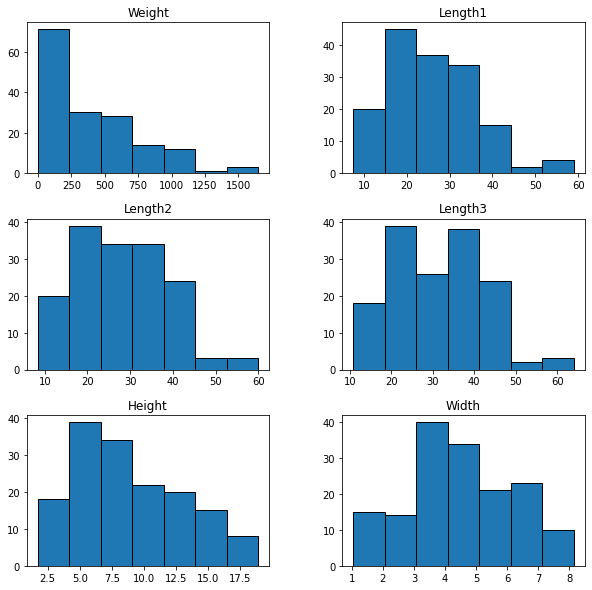

In [56]:
# Create histograms 
df.hist(figsize = (10, 10), grid = False, edgecolor = 'k', bins = 7);

> The quantitative data appears to be mostly right skewed. The 'Length3' features looks to be bimodal

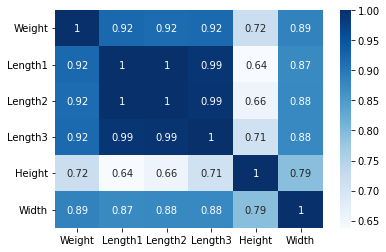

In [62]:
# Construct a heatmap
corr = df.corr()
sns.heatmap(corr, cmap = 'Blues', annot = True);

> This heatmap shows high linear correlation between a number of the features. This suggests that a linear regression model may perform well on this data.

# Split the data

In [43]:
# Set the features and target
X = df.drop(columns = 'Weight')
y = df['Weight']

In [45]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Construct a preprocessing pipeline

In [73]:
# Construct column selectors
cat_selector = make_column_selector(dtype_include = 'object')
num_selector = make_column_selector(dtype_include = 'number')

In [79]:
# Instantiate imputers
med_imputer = SimpleImputer(strategy = 'median')
freq_imputer = SimpleImputer(strategy = 'most_frequent')

In [80]:
# Construct pipelines
num_pipe = make_pipeline(med_imputer, StandardScaler())
cat_pipe = make_pipeline(freq_imputer, OneHotEncoder(sparse = False, handle_unknown = 'ignore'))

> We decided the median was a more appropriate choice since the data is skewed. Since our numeric data have different ranges we use a scaler
> Since the ranges of numeric data for the missing data fit within the ranges for the most frequent, we used a most_frequent strategy for imputing species names. Since the species names are not ordered, we will encode the species names using one hot encoding.

In [81]:
# Build tuples for a column transformer
cat_tuple = (cat_pipe, cat_selector)
num_tuple = (num_pipe, num_selector)

In [84]:
# Put the pipelines in a column transformer
col_transformer = make_column_transformer(cat_tuple, num_tuple, remainder = 'passthrough')

In [86]:
# Fit the column transformer using the traning data
col_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9bc6c917d0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._colum

In [87]:
# Process the data
X_train_processed = col_transformer.transform(X_train)
X_test_processed = col_transformer.transform(X_test)

# Construct models

## DecisionTree

In [102]:
# Construct a default decision tree model
dec_tree = DecisionTreeRegressor()
# Fit the decision tree to the processed traning data
dec_tree.fit(X_train_processed, y_train)
# Score the dufault model
print('Test Score:', dec_tree.score(X_test_processed, y_test))
print('Traning Score:', dec_tree.score(X_train_processed, y_train))

Test Score: 0.9418838504499577
Traning Score: 0.9999167769564986


In [104]:
# Get the hyperparameters
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [172]:
# Construct param_grid for grid search
param_grid_dt = {'max_depth': range(1, 10),
                 'min_samples_leaf': range(1, 5),
                 'min_samples_split': range(2, 10)}

In [176]:
# Tune the decision tree
dt_grid_search = GridSearchCV(dec_tree, param_grid_dt)
dt_grid_search.fit(X_train_processed, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 10)})

In [179]:
# Get the best parametirs
dt_grid_search.best_params_
# Get the best model
best_dt = dt_grid_search.best_estimator_

> Tuning our model is actually decreasing performance. This is okay since we are using cross-validation with grid search. 

In [189]:
# Evaluate the best model
dt_test_pred = best_dt.predict(X_test_processed)
dt_train_pred = best_dt.predict(X_train_processed)
print('Test MAE:', mean_absolute_error(y_test, dt_test_pred))
print('Train MAE:', mean_absolute_error(y_train, dt_train_pred))
print('Test MSE:', mean_squared_error(y_test, dt_test_pred))
print('Train_MSE:', mean_squared_error(y_train, dt_train_pred))
print('Test R2:', r2_score(y_test, dt_test_pred))
print('Train R2:', r2_score(y_train, dt_train_pred))

Test MAE: 55.87836309523809
Train MAE: 19.583373349339738
Test MSE: 8815.079438385772
Train_MSE: 863.2043077230892
Test R2: 0.9323931838406123
Train R2: 0.9931609757851122


The r2 score tells us our model accounts for about 93% of the variation of the data. Our MAE says a typical prediction is off by about 55 pounds. The RMSE is about 94 pounds, so our model is likely making some large errors.

## Random Forest

In [194]:
# Build a default random forest model
rf = RandomForestRegressor()
rf.fit(X_train_processed, y_train)
# Score the default model
print(rf.score(X_train_processed, y_train))
print(rf.score(X_test_processed, y_test))

0.9911730309810279
0.9648790977882088


In [196]:
# Get the hyperparameters of the default random forest
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [198]:
# Build a param_grid for grid search
param_grid_rf = {'max_depth': range(1, 5),
                 'min_samples_leaf': range(1, 5),
                 'min_samples_split': range(2, 5)}

In [201]:
# Tune the random forest using grid search
grid_search_rf = GridSearchCV(rf, param_grid_rf)
grid_search_rf.fit(X_train_processed, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 5),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 5)})

In [203]:
# Get the best parameters
grid_search_rf.best_params_

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 3}

In [205]:
# Get the best model
best_rf = grid_search_rf.best_estimator_

In [210]:
# Evaluate the tuned model
rf_test_pred = best_rf.predict(X_test_processed)
rf_train_pred = best_rf.predict(X_train_processed)
print('Test MAE:', mean_absolute_error(y_test, rf_test_pred))
print('Train MAE:', mean_absolute_error(y_train, rf_train_pred))
print('Test MSE:', mean_squared_error(y_test, rf_test_pred))
print('Train_MSE:', mean_squared_error(y_train, rf_train_pred))
print('Test R2:', r2_score(y_test, rf_test_pred))
print('Train R2:', r2_score(y_train, rf_train_pred))

Test MAE: 52.73998671549324
Train MAE: 28.22951052747197
Test MSE: 5987.758493785872
Train_MSE: 1852.9331627593667
Test R2: 0.9540771821143879
Train R2: 0.9853195186176652


> Our random forest model is able to explain about 95.4% of the data. We expect a typcial prediction to be off by about 53 pounds. Our RMSE of about 77 pounds shows our random forest is not making as many large errors as the decision tree.

# Final model

In [212]:
# Make the final model
final_model = best_rf

> We choose the random forest as our final model. It performed better on all metrics considered. It was able to explain 2% more of the variation and made fewer large errors. 